In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
tf.compat.v1.enable_v2_behavior()

In [3]:
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

In [4]:
from vectorincrement import *

# Running RL with tf.agents

In [280]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

In [281]:
v_n = 2
v_k = 2
v_seed = 43
do_transform = True
time_limit = 20

In [321]:
decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal')
    ]
)

In [282]:
def get_env():
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [283]:
train_env = get_env()
eval_env = get_env()

In [284]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu)

In [285]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [286]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [287]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [288]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

In [289]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [15]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)

step = 10: Average Return = 1.0 Train return = 7.900000095367432
step = 20: Average Return = 2.0 Train return = 7.5
step = 25: loss = -0.2913815379142761
step = 30: Average Return = 3.0 Train return = 8.0
step = 40: Average Return = 3.0 Train return = 7.800000190734863
step = 50: loss = -0.34632986783981323
step = 50: Average Return = 4.0 Train return = 7.599999904632568
step = 60: Average Return = 5.0 Train return = 8.199999809265137
step = 70: Average Return = 5.0 Train return = 8.399999618530273
step = 75: loss = -0.38549041748046875
step = 80: Average Return = 6.0 Train return = 8.300000190734863
step = 90: Average Return = 6.0 Train return = 7.599999904632568
step = 100: loss = -0.5429959297180176
step = 100: Average Return = 7.0 Train return = 9.0
step = 110: Average Return = 6.0 Train return = 8.199999809265137
step = 120: Average Return = 6.0 Train return = 8.0
step = 125: loss = -0.37788811326026917
step = 130: Average Return = 6.0 Train return = 8.5
step = 140: Average Return

Text(0.5, 0, 'Step')

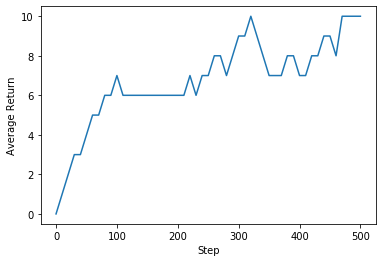

In [17]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')

In [290]:
replay_buffer.clear()
collect_episode(train_env, tf_agent.collect_policy, 10)

In [325]:
def encode_onehot(x, dim):
    """Encode x as 1-hot of dimension d."""
    assert x in range(dim)
    out = np.zeros(dim)
    out[x] = 1
    return out

def buffer_to_dataset(replay_buffer):
    """Create a dataset from a replay buffer."""
    types = replay_buffer.gather_all().step_type.numpy()[0]
    obs = replay_buffer.gather_all().observation.numpy()[0]
    acts = replay_buffer.gather_all().action.numpy()[0]

    xs = []
    ys = []

    for t, o, a in zip(types, obs, acts):
        oa = np.hstack([o, encode_onehot(a, v_n)])
        if t == 0:
            xs.append(oa)
        elif t == 1:
            xs.append(oa)
            ys.append(o)
        elif t == 2:
            ys.append(o)

    assert len(xs) == len(ys)
    
    return np.array(xs), np.array(ys)

In [340]:
def m_passthrough_action(decoder):
    """Create a model with last v_n components in input passed through."""
    inputs = tf.keras.Input(shape=(v_k + v_n,))

    decoded_obs = decoder(inputs[:, :v_k])
    passed_action = inputs[:, v_k:]

    merged = tf.keras.layers.Concatenate()([decoded_obs,  passed_action])

    model = tf.keras.Model(inputs=inputs, outputs=merged)
    
    return model

In [350]:
env_model = tf.keras.Sequential([
    m_passthrough_action(decoder),
    tf.keras.layers.InputLayer(input_shape=(v_k + v_n,)), # input: [state, one-hot action]
    tf.keras.layers.Dense(v_k) # output: state
])

env_model.compile('adam', 'mse')

In [351]:
xs, ys = buffer_to_dataset(replay_buffer)

In [353]:
env_model.fit(xs, ys, epochs=500)

Train on 200 samples
Epoch 1/500
200/200 [==============================] - 0s 766us/sample - loss: 0.5482
Epoch 2/500
200/200 [==============================] - 0s 40us/sample - loss: 0.5276
Epoch 3/500
200/200 [==============================] - 0s 41us/sample - loss: 0.5078
Epoch 4/500
200/200 [==============================] - 0s 40us/sample - loss: 0.4889
Epoch 5/500
200/200 [==============================] - 0s 44us/sample - loss: 0.4711
Epoch 6/500
200/200 [==============================] - 0s 41us/sample - loss: 0.4540
Epoch 7/500
200/200 [==============================] - 0s 46us/sample - loss: 0.4371
Epoch 8/500
200/200 [==============================] - 0s 42us/sample - loss: 0.4219
Epoch 9/500
200/200 [==============================] - 0s 63us/sample - loss: 0.4069
Epoch 10/500
200/200 [==============================] - 0s 46us/sample - loss: 0.3929
Epoch 11/500
200/200 [==============================] - 0s 39us/sample - loss: 0.3804
Epoch 12/500
200/200 [===================

200/200 [==============================] - 0s 43us/sample - loss: 0.0689
Epoch 97/500
200/200 [==============================] - 0s 43us/sample - loss: 0.0683
Epoch 98/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0677
Epoch 99/500
200/200 [==============================] - 0s 42us/sample - loss: 0.0671
Epoch 100/500
200/200 [==============================] - 0s 39us/sample - loss: 0.0666
Epoch 101/500
200/200 [==============================] - 0s 40us/sample - loss: 0.0661
Epoch 102/500
200/200 [==============================] - 0s 42us/sample - loss: 0.0655
Epoch 103/500
200/200 [==============================] - 0s 43us/sample - loss: 0.0650
Epoch 104/500
200/200 [==============================] - 0s 42us/sample - loss: 0.0646
Epoch 105/500
200/200 [==============================] - 0s 37us/sample - loss: 0.0641
Epoch 106/500
200/200 [==============================] - 0s 38us/sample - loss: 0.0636
Epoch 107/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 41us/sample - loss: 0.0371
Epoch 191/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0368
Epoch 192/500
200/200 [==============================] - 0s 44us/sample - loss: 0.0365
Epoch 193/500
200/200 [==============================] - 0s 47us/sample - loss: 0.0362
Epoch 194/500
200/200 [==============================] - 0s 40us/sample - loss: 0.0359
Epoch 195/500
200/200 [==============================] - 0s 52us/sample - loss: 0.0356
Epoch 196/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0353
Epoch 197/500
200/200 [==============================] - 0s 39us/sample - loss: 0.0349
Epoch 198/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0346
Epoch 199/500
200/200 [==============================] - 0s 43us/sample - loss: 0.0343
Epoch 200/500
200/200 [==============================] - 0s 46us/sample - loss: 0.0340
Epoch 201/500
200/200 [==============================] - 

200/200 [==============================] - 0s 42us/sample - loss: 0.0127
Epoch 285/500
200/200 [==============================] - 0s 58us/sample - loss: 0.0125
Epoch 286/500
200/200 [==============================] - 0s 50us/sample - loss: 0.0124
Epoch 287/500
200/200 [==============================] - 0s 45us/sample - loss: 0.0123
Epoch 288/500
200/200 [==============================] - 0s 52us/sample - loss: 0.0121
Epoch 289/500
200/200 [==============================] - 0s 44us/sample - loss: 0.0120
Epoch 290/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0119
Epoch 291/500
200/200 [==============================] - 0s 43us/sample - loss: 0.0117
Epoch 292/500
200/200 [==============================] - 0s 42us/sample - loss: 0.0116
Epoch 293/500
200/200 [==============================] - 0s 49us/sample - loss: 0.0115
Epoch 294/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0113
Epoch 295/500
200/200 [==============================] - 

200/200 [==============================] - 0s 47us/sample - loss: 0.0064
Epoch 379/500
200/200 [==============================] - 0s 49us/sample - loss: 0.0064
Epoch 380/500
200/200 [==============================] - 0s 51us/sample - loss: 0.0064
Epoch 381/500
200/200 [==============================] - 0s 54us/sample - loss: 0.0063
Epoch 382/500
200/200 [==============================] - 0s 57us/sample - loss: 0.0063
Epoch 383/500
200/200 [==============================] - 0s 44us/sample - loss: 0.0063
Epoch 384/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0062
Epoch 385/500
200/200 [==============================] - 0s 51us/sample - loss: 0.0062
Epoch 386/500
200/200 [==============================] - 0s 40us/sample - loss: 0.0062
Epoch 387/500
200/200 [==============================] - 0s 38us/sample - loss: 0.0062
Epoch 388/500
200/200 [==============================] - 0s 40us/sample - loss: 0.0061
Epoch 389/500
200/200 [==============================] - 

200/200 [==============================] - 0s 43us/sample - loss: 0.0044
Epoch 473/500
200/200 [==============================] - 0s 65us/sample - loss: 0.0044
Epoch 474/500
200/200 [==============================] - 0s 39us/sample - loss: 0.0044
Epoch 475/500
200/200 [==============================] - 0s 46us/sample - loss: 0.0043
Epoch 476/500
200/200 [==============================] - 0s 44us/sample - loss: 0.0043
Epoch 477/500
200/200 [==============================] - 0s 41us/sample - loss: 0.0043
Epoch 478/500
200/200 [==============================] - 0s 50us/sample - loss: 0.0043
Epoch 479/500
200/200 [==============================] - 0s 43us/sample - loss: 0.0043
Epoch 480/500
200/200 [==============================] - 0s 39us/sample - loss: 0.0042
Epoch 481/500
200/200 [==============================] - 0s 53us/sample - loss: 0.0042
Epoch 482/500
200/200 [==============================] - 0s 40us/sample - loss: 0.0042
Epoch 483/500
200/200 [==============================] - 

In [354]:
env_model.weights

[<tf.Variable 'dense_49/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.49919292, -0.7909084 ],
        [ 0.77810705, -0.43811953]], dtype=float32)>,
 <tf.Variable 'dense_52/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 0.03430925,  0.53939   ],
        [-0.43841517, -0.6861578 ],
        [-0.08981416, -0.15196005],
        [-0.12835124, -0.09376138]], dtype=float32)>,
 <tf.Variable 'dense_52/bias:0' shape=(2,) dtype=float32, numpy=array([0.08414647, 0.07566677], dtype=float32)>]

In [296]:
class CuriosityWrapper(wrappers.PyEnvironmentBaseWrapper):
    """Adds a model loss component to the reward."""

    def __init__(self, env, model, alpha=1.0):
        """Initialize.
        
        Args:
            env: tf.agents environment
            model: keras model [observation + one-hot action] -> observation
            alpha: how much l2 norm loss for the model to add to the reward  
        """
        super(CuriosityWrapper, self).__init__(env)

        # saved old time-step
        self.old_step = None

        # keras model taking [obs + one-hot action] and outputting next obs
        self.model = model

        def model_for_obs_and_action(obs, act):
            """Take observation and action as a number, return next observation."""
            z = [np.hstack([obs, encode_onehot(act, v_n)])]
            z = np.array(z)
            return self.model(z)
        self.model_for_obs_and_action = model_for_obs_and_action

        self.last_action = None
        
        self.alpha = alpha

    def transform_step(self, step):
        """Replace a reward inside the step to a curiosity reward (r + model loss)"""
        
        # reward to add
        r = 0

        # resetting old step, if required
        if step.step_type == 0:
            self.old_step = None

        # computing the curiosity reward
        if self.old_step is not None:
            # observation predicted by the model
            pred_obs = self.model_for_obs_and_action(
                self.old_step.observation,
                self.last_action)
            
            # computing the reward as l2 norm for the difference
            r = np.linalg.norm(pred_obs - step.observation, ord=1) / np.linalg.norm(step.observation, ord=1)
            print(pred_obs, step.observation)
        
        # remembering previous step
        self.old_step = step

        # computing the next reward
        total_reward = step.reward + r

        # returning a step with modified reward
        total_reward = np.asarray(total_reward,
                                  dtype=np.asarray(step.reward).dtype)


        return ts.TimeStep(step.step_type, total_reward, step.discount,
                           step.observation)

    def _reset(self):
        return self.transform_step(self._env.reset())

    def _step(self, action):
        # saving the action for transform_step
        self.last_action = action
        return self.transform_step(self._env.step(action))

In [297]:
env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                        do_transform=do_transform)
env = wrappers.TimeLimit(env, time_limit)
env = CuriosityWrapper(env, env_model, alpha=1.0)

In [298]:
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0., 0.], dtype=float32))

In [320]:
env.step(1)

tf.Tensor([[-0.05536565 -0.02697793]], shape=(1, 2), dtype=float32) [-0.03624179 -0.02725032]


TimeStep(step_type=array(1, dtype=int32), reward=array(0.30120066, dtype=float32), discount=array(1., dtype=float32), observation=array([-0.03624179, -0.02725032], dtype=float32))